In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA, AR, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df=pd.read_csv('zillow_data.csv')

In [3]:
df.head(9)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [4]:
df.dropna(inplace=True)

In [5]:
df_values=df.drop(columns=['RegionID','RegionName','City','State','Metro','CountyName','SizeRank'])

In [6]:
df_values['Monthly Standard Deviation']=df_values.std(axis=1)

In [7]:
low_std=df_values[df_values['Monthly Standard Deviation']< 3.485439e+04]

In [8]:
low_std['Average Monthly Return']=low_std.pct_change(axis=1).mean(axis=1)

/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
target_zips=low_std[low_std['Average Monthly Return']>.06]

# Arima model for my first zipcode that has low variance but a high return 93144

In [10]:
el_passo93144=pd.DataFrame(df_values.iloc[4,:-2])

In [11]:
el_passo93144

,4
1996-04,77300.0
1996-05,77300.0
1996-06,77300.0
1996-07,77300.0
1996-08,77400.0
...,...
2017-11,120300.0
2017-12,120300.0
2018-01,120300.0
2018-02,120500.0


In [12]:
el_passo93144=el_passo93144.set_index(pd.to_datetime(el_passo93144.index))

/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


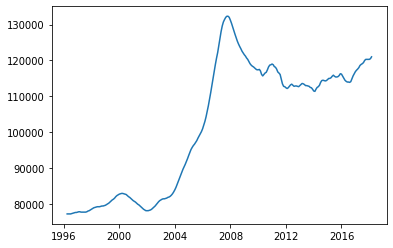

In [13]:
plt.plot(el_passo93144)

In [14]:
# deciding how i want to split up my training and test variables

In [15]:
len(el_passo93144)

264

In [16]:
264*.8

211.20000000000002

In [17]:
el_passo93144.rename(columns={4:'value'},inplace=True)

In [18]:
X=el_passo93144['value']
train=X[:211]
test=X[211:]

In [19]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))


/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [20]:
res=sarimax.fit(disp=False)

In [21]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              value   No. Observations:                  211
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1547.851
Date:                            Thu, 16 Apr 2020   AIC                           3105.701
Time:                                    09:38:53   BIC                           3122.142
Sample:                                04-01-1996   HQIC                          3112.356
                                     - 10-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8192      0.018     44.463      0.000       0.783       0.855
ma.L1         -0.5412      0.022    -24.601      0.000      -0.584      -0.498
ar.S.L12       0.1955      0.166      1.180      0.238      -0.129       0.520
ma.S.L12      -0.3879      0.176     -2.199      0.028      -0.734      -0.042
sigma2      1.451e+05    1.1e+04     13.254      0.000    1.24e+05    1.67e+05
===================================================================================
Ljung-Box (Q):                      266.50   Jarque-Bera (JB):               595.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.67
Prob(H) (two-sided):                  0.73   Kurtosis:                        11.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
forecast=res.get_prediction(start=211,end=288,dynamic=True)
#forecasttest=res.predict()

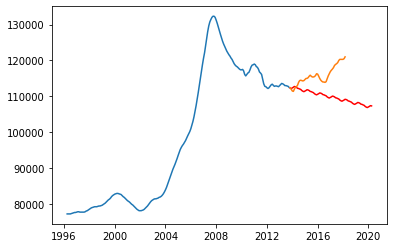

In [36]:
plt.plot(forecast.predicted_mean,color='red')
plt.plot(train)
plt.plot(test)

In [75]:
np.sqrt(mse(test,forecast.predicted_mean))

6167.113264338686

# Second Zipcode

In [76]:
houston_91733=pd.DataFrame(df_values.iloc[5,:-2])

In [77]:
houston_91733

,5
1996-04,95000.0
1996-05,95200.0
1996-06,95400.0
1996-07,95700.0
1996-08,95900.0
...,...
2017-11,162800.0
2017-12,162800.0
2018-01,162800.0
2018-02,162900.0


In [78]:
houston_91733=houston_91733.set_index(pd.to_datetime(houston_91733.index))

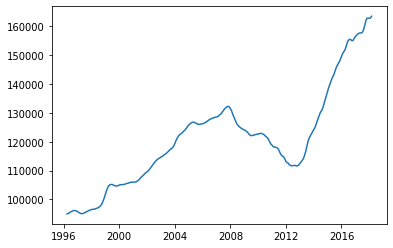

In [79]:
plt.plot(houston_91733)

In [80]:
len(houston_91733)
#print(len(houston_91733)*.8)

264

In [81]:
houston_91733.rename(columns={5:'value'},inplace=True)


In [82]:
X=houston_91733['value']
train=X[:211]
test=X[211:]


In [83]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [84]:
res=sarimax.fit(disp=False)

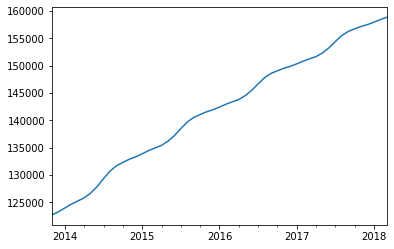

In [89]:
forecast=res.get_prediction(start=211,end=263,dynamic=True)
forecast.predicted_mean.plot()
#confidence interval

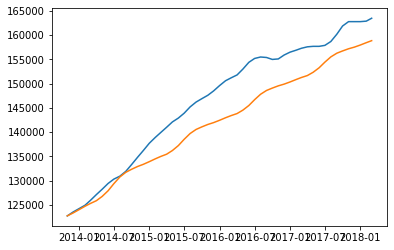

In [90]:
plt.plot(test)
plt.plot(forecast.predicted_mean)

In [91]:
np.sqrt(mse(test,forecast.predicted_mean))

5189.383533071969

In [92]:
# 3rd zip code

In [93]:
Houston_91940=pd.DataFrame(df_values.iloc[8,:-2])

In [94]:
Houston_91940

,8
1996-04,95400.0
1996-05,95600.0
1996-06,95800.0
1996-07,96100.0
1996-08,96400.0
...,...
2017-11,170900.0
2017-12,172300.0
2018-01,173300.0
2018-02,174200.0


In [95]:
Houston_91940.rename(columns={8:'value'},inplace=True)

In [96]:
Houston_91940=Houston_91940.set_index(pd.to_datetime(Houston_91940.index))

In [97]:
print(len(Houston_91940)*.8)

211.20000000000002


In [98]:
X=Houston_91940['value']
train=X[:211]
test=X[211:]


In [99]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [100]:
res=sarimax.fit(disp=False)

/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [101]:
forecast=res.get_prediction(start=211,end=262)

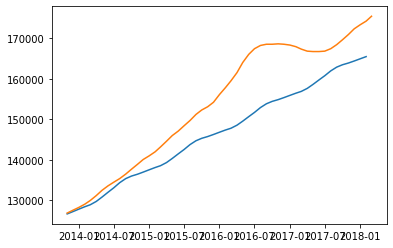

In [102]:
plt.plot(forecast.predicted_mean)
plt.plot(test)

In [103]:
np.sqrt(mse(test,forecast.predicted_mean))

ValueError: Found input variables with inconsistent numbers of samples: [53, 52]

# zipcode 4

In [ ]:
#identify seasonality 
#decompisition 


In [205]:
nashville_74101=pd.DataFrame(df_values.iloc[14,:-2])

In [206]:
nashville_74101.rename(columns={14:'value'},inplace=True)

In [207]:
nashville_74101=nashville_74101.set_index(pd.to_datetime(nashville_74101.index))

In [208]:
X=nashville_74101['value']
train=X[:211]
test=X[211:]


In [209]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [210]:
res=sarimax.fit(disp=False)

/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [293]:
forecast=res.get_prediction(start=211,end=262)

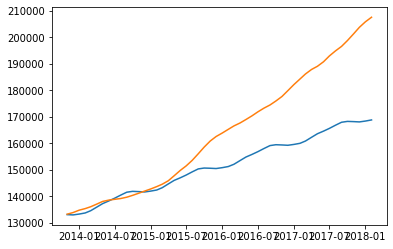

In [212]:
plt.plot(forecast)
plt.plot(test)

In [294]:
np.sqrt(mse(test,forecast))

TypeError: Expected sequence or array-like, got <class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>

# zipcode 5

In [217]:
pfulugerville_78660=pd.DataFrame(df_values.iloc[18,:-2])

In [218]:
pfulugerville_78660.rename(columns={18:'value'},inplace=True)

In [219]:
pfulugerville_78660=pfulugerville_78660.set_index(pd.to_datetime(pfulugerville_78660.index))

In [220]:
X=pfulugerville_78660['value']
train=X[:211]
test=X[211:]


In [221]:
sarimax=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))

/Users/sabirrahmanny/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [222]:
res=sarimax.fit(disp=False)

In [295]:
forecast=res.get_prediction(start=211,end=262)

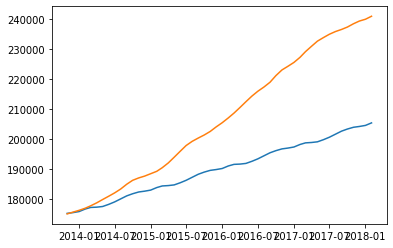

In [224]:
plt.plot(forecast)
plt.plot(test)

In [225]:
np.sqrt(mse(test,forecast))

20835.101449209462

# trying to improve baseline

In [368]:
el_passo93144

,value
1996-04-01,77300.0
1996-05-01,77300.0
1996-06-01,77300.0
1996-07-01,77300.0
1996-08-01,77400.0
...,...
2017-10-01,120300.0
2017-11-01,120300.0
2017-12-01,120300.0
2018-01-01,120300.0


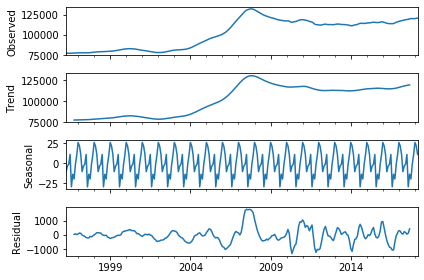

<Figure size 720x720 with 0 Axes>

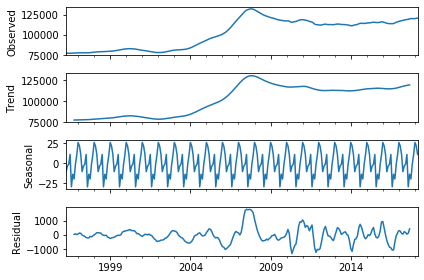

In [27]:

from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(10,10))
result = seasonal_decompose(el_passo93144, model='additive')
result.plot()

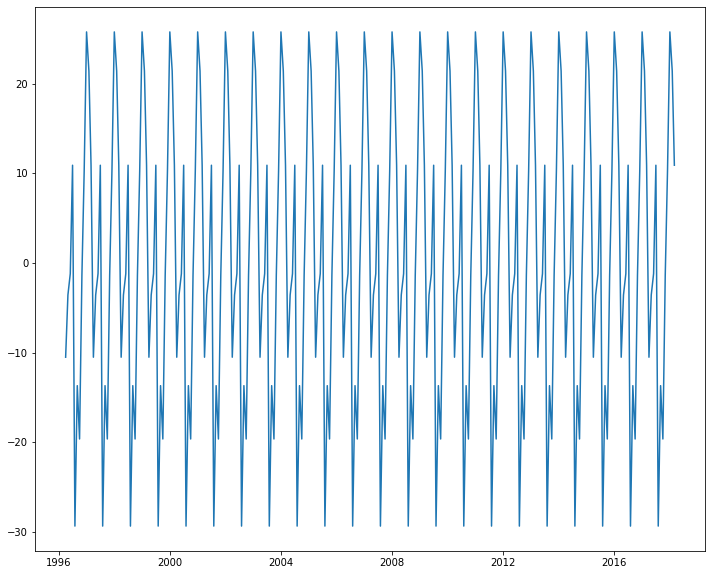

In [34]:
plt.figure(figsize=(12,10))
plt.plot(result.seasonal)

In [ ]:
def lowest_rmse(p,d,q):
    x
    